# Customer Segmentation Using RFM Analysis

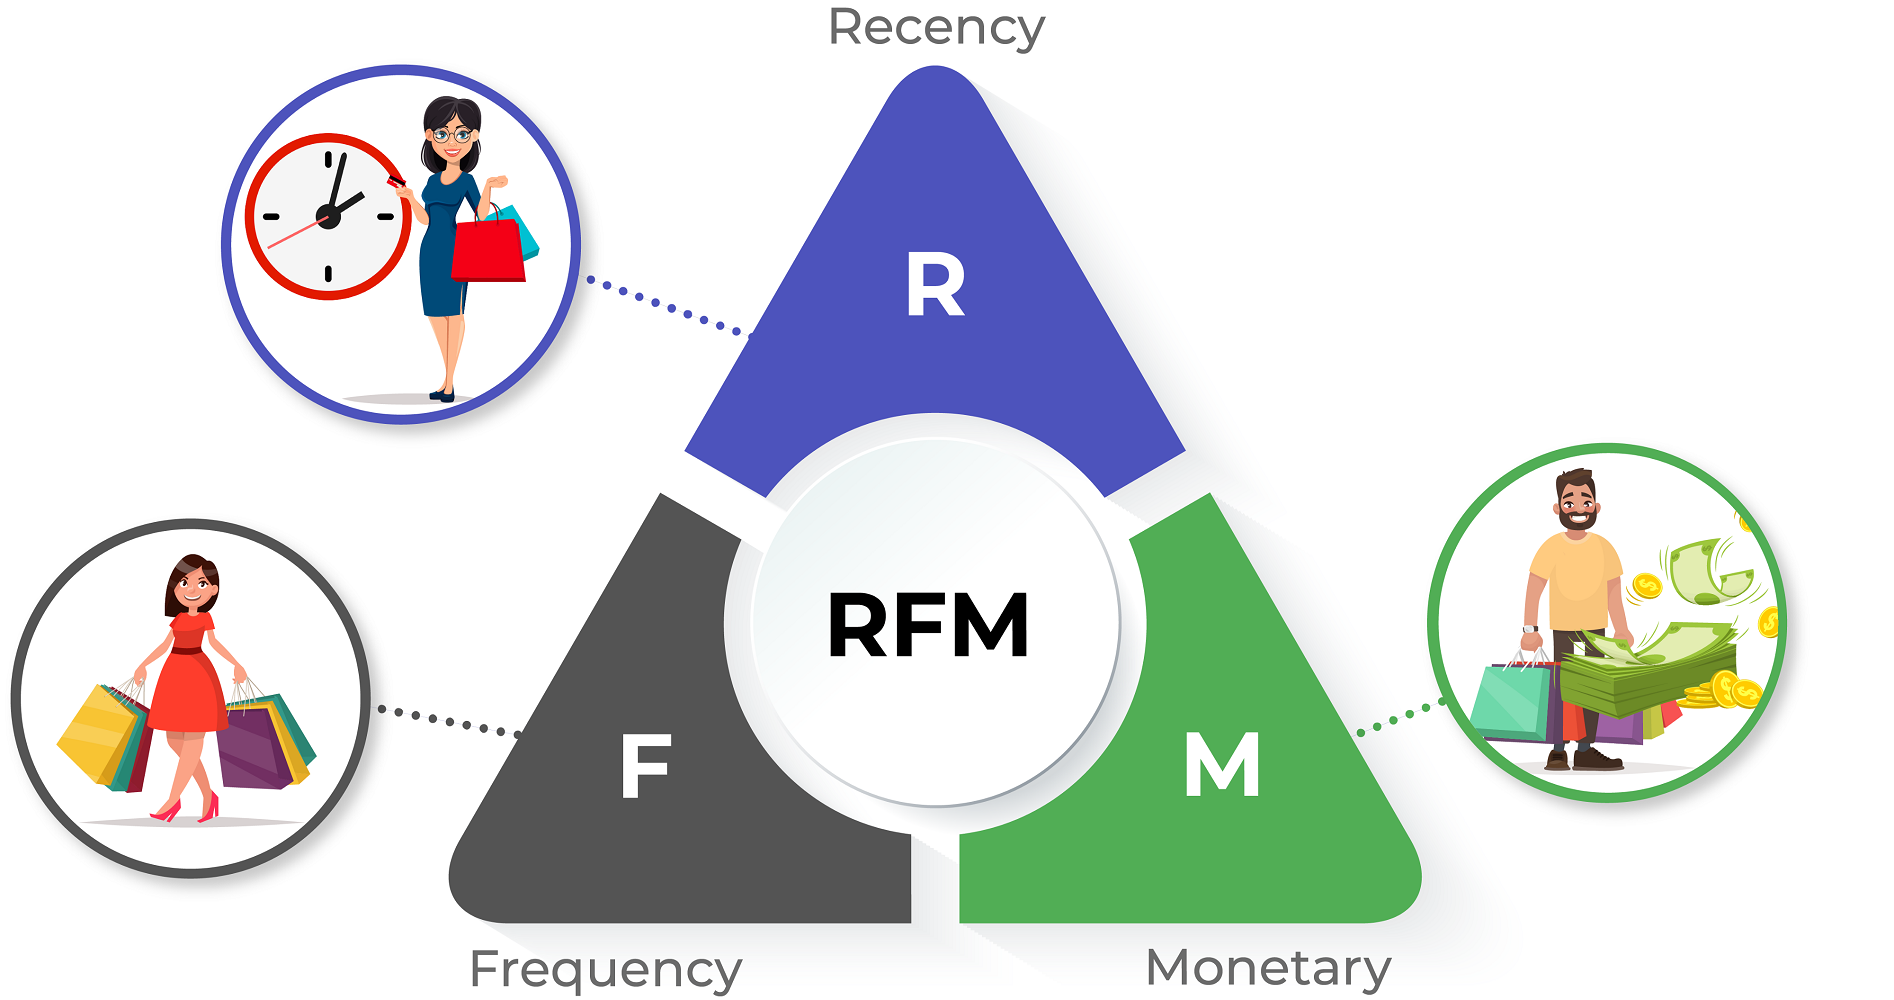

**What is RFM Analysis?**

RFM analysis is a technique used to categorize customers according to their purchasing behaviour.

**How we can calculate?**

Recency: This is the date when the customer made the last purchase. It is calculated by subtracting the customer's last shopping date from the analysis date.

Frequency: This is the total number of purchases of the customer. In a different way, it gives the frequency of purchases made by the customer.

Monetary: It is the total monetary value spent by the customer.

**Business Problem**

An e-commerce company wants to segment its customers and determine marketing strategies according to these segments. For example, it is desirable to organize different campaigns to retain customers who are very profitable for the company, and different campaigns for new customers.

**About Dataset**

The Online Retail II data set includes the sales of an online retail store based in the UK between dec1/12/2009 and 09/12/2011. The product catalog of this company includes souvenirs. The vast majority of the company's customers are corporate customers.

**Variables**

*   InvoiceNo: Invoice number. A unique number for each transaction. If it starts with C which means cancelled operations.
*   StockCode: Product code. A unique number for each product.
*   Description: Product name.
*   Quantity: It refers to how many of the products in the invoices have been sold.
*   InvoiceDate: Invoice date.
*   UnitPrice: Product price (pound)
*   CustomerID: Unique customer number.
*   Country: The name of the country where the customer lives.

**Importing Libraries**

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # Uyarılar
warnings.filterwarnings("ignore")

In [2]:
!pip install openpyxl

**Reading and Investigation of the Data**

In [31]:
#Reading and copy of data
online_retail = pd.read_excel('online_retail_II.xlsx', sheet_name="Year 2010-2011")
df = online_retail.copy()

In [32]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [33]:
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France
541909,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France


In [34]:
df.shape

(541910, 8)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0,9.552234,218.080957,-80995.00,1.00,3.00,10.00,80995.0
Price,541910.0,4.611138,96.759765,-11062.06,1.25,2.08,4.13,38970.0
Customer ID,406830.0,15287.684160,1713.603074,12346.00,13953.00,15152.00,16791.00,18287.0


In [37]:
#Investigating null values
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [38]:
#Remove the missing observations from the dataset
df.dropna(inplace=True)

In [39]:
#Investigating unique items in dataset
df["Description"].nunique()

3896

In [40]:
#Lets see how many different products in dataset
df["Description"].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2070
REGENCY CAKESTAND 3 TIER              1905
JUMBO BAG RED RETROSPOT               1662
ASSORTED COLOUR BIRD ORNAMENT         1418
PARTY BUNTING                         1416
                                      ... 
VINTAGE BLUE TINSEL REEL                 1
SET OF 3 PINK FLYING DUCKS               1
CAKE STAND LACE WHITE                    1
ANTIQUE RASPBERRY FLOWER EARRINGS        1
FUNKY MONKEY MUG                         1
Name: Description, Length: 3896, dtype: int64

In [41]:
#Top 5 most ordered products
df.groupby("Description").agg({"Quantity":"sum"}).sort_values("Quantity", ascending=False).head(5)

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53215
JUMBO BAG RED RETROSPOT,45066
ASSORTED COLOUR BIRD ORNAMENT,35314
WHITE HANGING HEART T-LIGHT HOLDER,34147
PACK OF 72 RETROSPOT CAKE CASES,33409


In [42]:
#Remove the canceled transactions from the dataset
df = df[~df["Invoice"].str.contains("C", na=False)]

In [43]:
#We are creating new column just multiplying 'Price' and 'Quantity' for having total amount of each invoice
df["TotalPrice"] = df["Quantity"] * df["Price"]

**Calculating RFM Metrics**

In [44]:
#Determining the analysis date for the recency 
df["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
rfm.columns=["Recency","Frequency","Monetary"]
rfm = rfm[rfm["Monetary"] > 0]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4338.0,93.059474,100.012264,1.00,18.000,51.000,142.75,374.00
Frequency,4338.0,4.272706,7.706221,1.00,1.000,2.000,5.00,210.00
Monetary,4338.0,2054.270609,8989.229895,3.75,307.415,674.485,1661.74,280206.02


**Converting RFM Scores to Single Variables**

In [45]:
#Date from customer's last purchase.The nearest date gets 5 and the furthest date gets 1.
rfm["recency_score"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
# Total number of purchases.The least frequency gets 1 and the maximum frequency gets 5.
rfm["frequency_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
#Total spend by the customer. The least money gets 1, the most money gets 5.
rfm["monetary_score"]= pd.qcut(rfm["Monetary"],5,labels=[1,2,3,4,5])
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score
Customer ID,,,,,,
12346.0,326,1,77183.60,1,1,5
12347.0,3,7,4310.00,5,5,5
12348.0,76,4,1797.24,2,4,4
12349.0,19,1,1757.55,4,1,4
12350.0,311,1,334.40,1,1,2


**RFM Score**

In [46]:
#The value of 2 different variables that were formed was recorded as a RFM_SCORE
rfm["RFM_SCORE"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str))

**Segmenting Customers by Using RFM Score**

In [49]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.reset_index(inplace=True)
rfm.head()

,Customer ID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346.0,326,1,77183.60,1,1,5,11,hibernating
1,12347.0,3,7,4310.00,5,5,5,55,champions
2,12348.0,76,4,1797.24,2,4,4,24,at_Risk
3,12349.0,19,1,1757.55,4,1,4,41,promising
4,12350.0,311,1,334.40,1,1,2,11,hibernating


**Interpretation of Descriptive Statistics of Segments**

In [50]:
rfm[["segment", "Recency","Frequency","Monetary"]].groupby("segment").agg(["mean","count","max"]).round()

Recency            Frequency  ...      Monetary                
                       mean count  max      mean  ...  max     mean count       max
segment                                           ...                              
about_to_sleep         53.0   352   72       1.0  ...    2    472.0   352    6208.0
at_Risk               154.0   593  374       3.0  ...    6   1085.0   593   44534.0
cant_loose            133.0    63  373       8.0  ...   34   2796.0    63   10254.0
champions               6.0   633   13      12.0  ...  210   6858.0   633  280206.0
hibernating           218.0  1071  374       1.0  ...    2    489.0  1071   77184.0
loyal_customers        34.0   819   72       6.0  ...   63   2864.0   819  124915.0
need_attention         52.0   187   72       2.0  ...    3    898.0   187   12602.0
new_customers           7.0    42   13       1.0  ...    1    388.0    42    3861.0
potential_loyalists    17.0   484   33       2.0  ...    3   1041.0   484  168472.0
promising              24.0    94   33       1.0  ...    1    294.0    94    1758.0

[10 rows x 9 columns]

In [51]:
rfm.groupby('segment').agg({"Customer ID":"count"}).sort_values("Customer ID",ascending=False)

,Customer ID
segment,
hibernating,1071
loyal_customers,819
champions,633
at_Risk,593
potential_loyalists,484
about_to_sleep,352
need_attention,187
promising,94
cant_loose,63


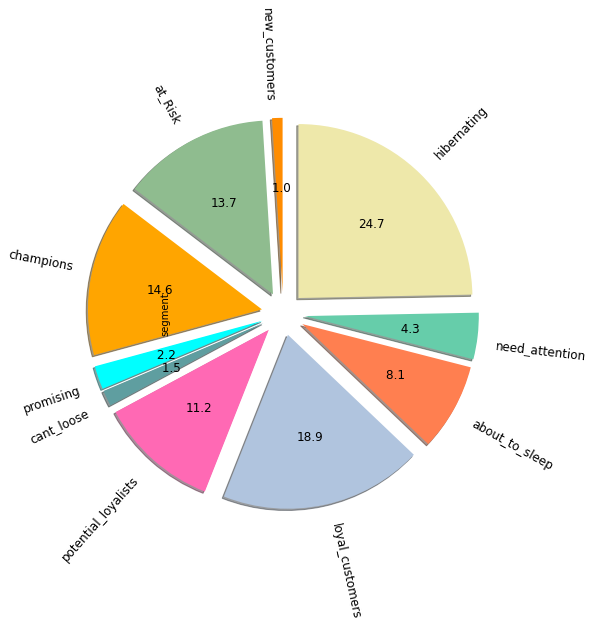

In [52]:
colors  = ("darkorange", "darkseagreen", "orange", "cyan", "cadetblue", "hotpink", "lightsteelblue", "coral",  "mediumaquamarine","palegoldenrod")
explodes = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]

rfm["segment"].value_counts(sort=False).plot.pie(colors=colors,
                                                 textprops={'fontsize': 12}, 
                                                 autopct = '%4.1f',
                                                 startangle= 90, 
                                                 radius =2, 
                                                 rotatelabels=True,
                                                 shadow = True, 
                                                 explode = explodes)

In [53]:
rfm[["segment", "Recency","Frequency","Monetary"]].groupby("segment").agg(["mean","count","max"]).round()

Recency            Frequency  ...      Monetary                
                       mean count  max      mean  ...  max     mean count       max
segment                                           ...                              
about_to_sleep         53.0   352   72       1.0  ...    2    472.0   352    6208.0
at_Risk               154.0   593  374       3.0  ...    6   1085.0   593   44534.0
cant_loose            133.0    63  373       8.0  ...   34   2796.0    63   10254.0
champions               6.0   633   13      12.0  ...  210   6858.0   633  280206.0
hibernating           218.0  1071  374       1.0  ...    2    489.0  1071   77184.0
loyal_customers        34.0   819   72       6.0  ...   63   2864.0   819  124915.0
need_attention         52.0   187   72       2.0  ...    3    898.0   187   12602.0
new_customers           7.0    42   13       1.0  ...    1    388.0    42    3861.0
potential_loyalists    17.0   484   33       2.0  ...    3   1041.0   484  168472.0
promising              24.0    94   33       1.0  ...    1    294.0    94    1758.0

[10 rows x 9 columns]

**Conclusion**

For instance let's take 3 groups for analysing and mentioning what actions can a company take for these groups.


* Can't Loose
> We have 63 customers there. It seems a bit less. Maybe you say there is no need for giving attention for them but they need. Monetary is 2796. It is greater than need_attention segment although they are few in number. Also it is near to loyal_customer segment. But their average recency is 133. In addition to the methods we apply for the need_attention segment, customers can be called and questions about their shopping satisfaction can be asked. For their next shopping, a discount can be applied and a gift sample can be sent from new products

* Need Attention
>  We have 187 customers. Monetary is 898, almost 1/3 of loyal customers. There is great potential here. Frequency of customers 52. Campaigns can be sent via sms or e-mail to encourage shopping. In order to reduce the frequency of this segment, gift certificates can be sent and they can be reminded of the products.


*   Loyal Customers
> We have 819 customers in this segment. Monetary is 2864 Recency is 34 and frequency is 6. We can encourage this segment for the championship. When we come with offers such as free shipping for champions, this segment can also request the same earnings and push their segment up.












